# K-Nearest Neighbors (KNN) — Churn Prediction

This notebook implements a **KNN classifier** for the bank customer churn dataset.

Because the dataset is **imbalanced**, we avoid accuracy-based tuning and instead
optimize **F1-score** and evaluate using **ROC-AUC**.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path



from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve
)


## Load Preprocessed Data

This notebook assumes that EDA and preprocessing files has already been made and
produced the following variables:

- `X_train`, `X_test`
- `y_train`, `y_test`


In [15]:

# Relative path from notebooks/models/ to data/processed/
processed_dir = Path('../../data/processed')

print("Looking for CSV files in:", processed_dir.resolve())

# Load CSVs
X_train = pd.read_csv(processed_dir / 'X_train_scaled.csv')
X_test  = pd.read_csv(processed_dir / 'X_test_scaled.csv')
y_train = pd.read_csv(processed_dir / 'y_train.csv')['churn']
y_test  = pd.read_csv(processed_dir / 'y_test.csv')['churn']

print("Data loaded successfully!")
print("Shapes:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)




Looking for CSV files in: C:\Users\senki\CustomerChurn\data\processed
Data loaded successfully!
Shapes:
X_train: (8000, 15)
X_test:  (2000, 15)
y_train: (8000,)
y_test: (2000,)


## Choosing K for Imbalanced Data

Accuracy is misleading for churn prediction due to class imbalance.

We therefore select the number of neighbors (**k**) using **F1-score**, which
balances precision and recall for the minority (churn) class.


In [5]:
k_values = range(1, 31)
f1_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred))


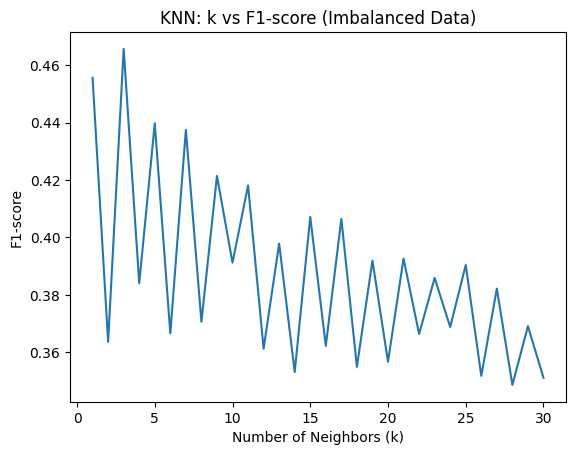

In [6]:
plt.figure()
plt.plot(k_values, f1_scores)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("F1-score")
plt.title("KNN: k vs F1-score (Imbalanced Data)")
plt.show()


In [7]:
best_k = k_values[np.argmax(f1_scores)]
best_k


3

## Train Final KNN Model

We now train the final KNN model using the value of **k** that maximizes F1-score.


In [8]:
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)


,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [9]:
y_pred = knn_final.predict(X_test)
y_proba = knn_final.predict_proba(X_test)[:, 1]


In [10]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[1486  107]
 [ 251  156]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1593
           1       0.59      0.38      0.47       407

    accuracy                           0.82      2000
   macro avg       0.72      0.66      0.68      2000
weighted avg       0.80      0.82      0.81      2000

ROC-AUC: 0.7383323230780858


## ROC Curve

The ROC curve evaluates how well the model ranks churners above non-churners,
independent of any specific classification threshold.


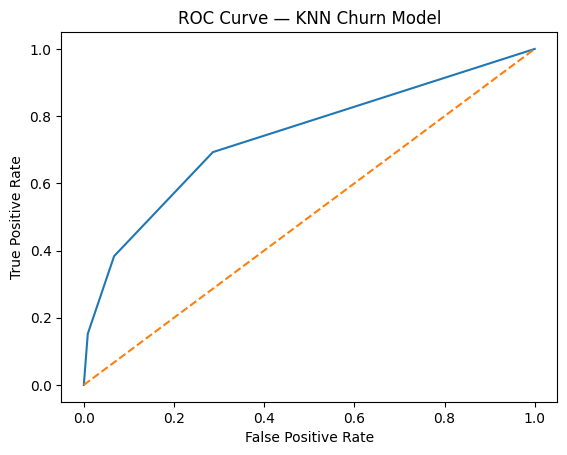

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — KNN Churn Model")
plt.show()


## Summary

- KNN was trained on **scaled features**
- The hyperparameter **k** was selected using **F1-score**
- ROC-AUC confirms the model’s ranking capability

This evaluation strategy is appropriate for **imbalanced churn prediction**.
